## Import dependencies

In [1]:
%load_ext autoreload
%autoreload 2
from datetime import datetime
import numpy as np
import pandas_datareader as pdr
from datetime import datetime
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from functools import partial
from scipy.integrate import quad

from matplotlib import pyplot as plt
import utils
import alPhaStablePricer as alpha
import ghPricer as gh
import mertonPricer as merton
#st.levy_stable.pdf_default_method = 'quadrature' #More acurate but slow method

## Read data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-06-21,24.087500,23.670000,23.735001,23.977501,142185600.0,22.399418
2016-06-22,24.222500,23.837500,24.062500,23.887501,116876400.0,22.315344
2016-06-23,24.072500,23.812500,23.985001,24.025000,128960800.0,22.443794
2016-06-24,23.665001,23.162500,23.227501,23.350000,301245600.0,21.813219
2016-06-27,23.262501,22.875000,23.250000,23.010000,181958400.0,21.495594
...,...,...,...,...,...,...
2021-06-14,130.539993,127.070000,127.820000,130.479996,96906500.0,130.479996
2021-06-15,130.600006,129.389999,129.940002,129.639999,62746300.0,129.639999
2021-06-16,130.889999,128.460007,130.369995,130.149994,91815000.0,130.149994


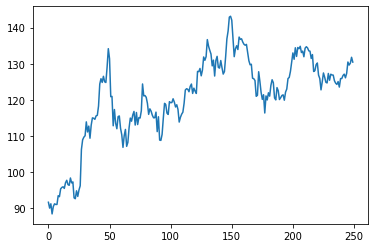

In [2]:
df = pdr.data.DataReader("AAPL",'yahoo', #"av-intraday",
                         end=datetime.today(),
                         api_key="ZDT39A5EINVODTVI")
display(df)
df["Close"][-250:].plot(use_index=False)
initial_value=df["Close"][-1]
df.index = pd.to_datetime(df.index)

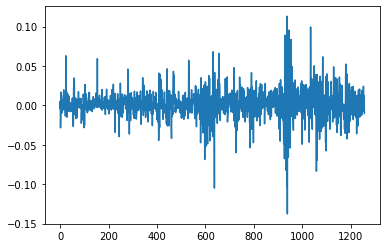

Date
2016-06-22   -0.003761
2016-06-23    0.005740
2016-06-24   -0.028498
2016-06-27   -0.014668
2016-06-28    0.016700
Name: Close, dtype: float64

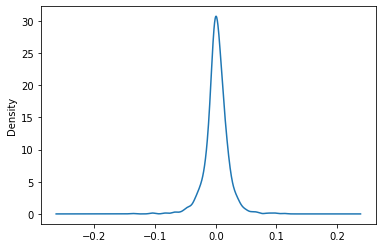

In [3]:
df = pd.Series(np.log(df.Close) - np.log(df.Close.shift(1))[1:],index=df.index[1:])
df.plot(use_index=False)
plt.show()
df.plot.kde()
df.head()

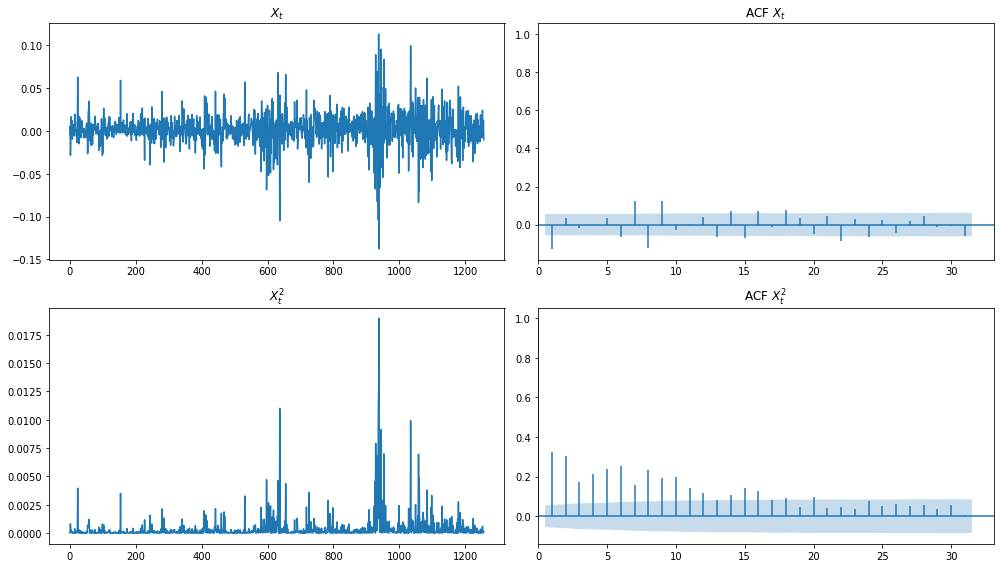

In [4]:
def tsplot(y, figsize=(14, 8),xlim=(-0.1,0.1)):

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    ac_ax = plt.subplot2grid(layout, (0, 1))
    ts_ax2  = plt.subplot2grid(layout, (1, 0))
    ac_ax2 = plt.subplot2grid(layout, (1, 1))
    
    y2=pd.Series([x**2 for x in y])

    y.plot(ax=ts_ax,use_index=False,title=r'$X_t$')
    y2.plot(ax=ts_ax2,use_index=False,title=r'$X_t^2$')
    
    smt.graphics.plot_acf(y, lags=None, ax=ac_ax,marker=None,title=r'ACF $X_t$')
    smt.graphics.plot_acf(y2, lags=None, ax=ac_ax2,marker=None,title=r'ACF $X_t^2$')
    
    [ax.set_xlim(0) for ax in [ac_ax, ac_ax2]]

    
    fig.tight_layout()
    plt.show()
tsplot(df)

## Data subset

In [5]:
dataset = df[-250:]

In [6]:
dataset

Date
2020-06-23    0.021120
2020-06-24   -0.017810
2020-06-25    0.013188
2020-06-26   -0.031208
2020-06-29    0.022785
                ...   
2021-06-14    0.024281
2021-06-15   -0.006459
2021-06-16    0.003926
2021-06-17    0.012522
2021-06-18   -0.010143
Name: Close, Length: 250, dtype: float64

In [7]:
print("Shapiro test of normality: statistic={}, p_value={}".format(st.shapiro(dataset)[0],st.shapiro(dataset)[1]))

Shapiro test of normality: statistic=0.977552592754364, p_value=0.00054467300651595


In [8]:
print("Jarque Bera test of normality: statistic={}, p_value={}".format(st.jarque_bera(dataset)[0],st.shapiro(dataset)[1]))

Jarque Bera test of normality: statistic=48.39947581560408, p_value=0.00054467300651595


We can reject the null hypothesis H0 that the returns are normally distributed

## Fit models

In [9]:
alpha_model = alpha.AlPhaStablePricer()

In [ ]:
%%time
alpha_model.fit(dataset)

In [ ]:
merton_model = merton.MertonPricer()

In [ ]:
%%time
merton_model.fit(dataset,T=1)

In [ ]:
gh_model = gh.GhPricer()

In [ ]:
%%time
gh_model.fit(dataset,1000)

## Probability density

In [ ]:
N=100
x_grid = np.linspace(dataset.min(),dataset.max(),N)

plt.plot(x_grid,
        [merton_model.Merton_density(j,
                                     T=1,
                                     lam= merton_model.lam,
                                     mu=merton_model.mu,
                                     muJ=merton_model.muJ,
                                     sig=merton_model.sig,
                                     sigJ=merton_model.sigJ) for j in x_grid],
        label="Merton",linestyle='--')


plt.plot(x_grid,
         [st.levy_stable.pdf(x, 
                          alpha=alpha_model.alpha,
                          beta=alpha_model.betta,
                          loc=alpha_model.mu,
                          scale=alpha_model.c) for x in x_grid],
        label=r'$\alpha$-Stable',linestyle='--')


plt.plot(x_grid,
        [gh_model.GH_density(j,
                             alpha= gh_model.alpha,
                             betta=gh_model.betta,
                             delta=gh_model.delta,
                             lam=gh_model.lam,
                             mu=gh_model.mu) for j in x_grid],
        label="GH",linestyle='--')

dataset.plot.kde(label="KDE")
plt.xlim((-dataset.max(),dataset.max()))
plt.legend()
plt.title("PDF")
plt.show()

## Cumulative distribution function

In [ ]:
p_Merton = partial(merton_model.Merton_density,
                  T=1,
                  lam= merton_model.lam,
                  mu=merton_model.mu,
                  muJ=merton_model.muJ,
                  sig=merton_model.sig,
                  sigJ=merton_model.sigJ)

p_GH = partial(gh_model.GH_density,
               delta=gh_model.delta,
               mu=gh_model.mu,
               lam=gh_model.lam,
               alpha=gh_model.alpha,
               betta=gh_model.betta)


plt.plot(x_grid,
        [quad(p_Merton,-np.inf,x)[0] for x in x_grid],
        label="Merton",linestyle='--')

plt.plot(x_grid,
        [quad(p_GH,-np.inf,x)[0] for x in x_grid],
        label="GH",linestyle='--')

plt.plot(x_grid,  
        [st.levy_stable(alpha=alpha_model.alpha,
                        beta=alpha_model.betta,
                        loc=alpha_model.mu,
                        scale=alpha_model.c).cdf(x) for x in x_grid],
        label=r'$\alpha$-Stable',linestyle='--')
 
plt.plot(np.sort(dataset), 1. * np.arange(len(dataset)) / (len(dataset) - 1),label="Empirical CDF")
plt.legend()
plt.title("CDF")
plt.show()


### AIC

In [ ]:
pd.DataFrame({"Merton":merton_model.aic,
              "GH":gh_model.aic,
              "Alpha-Stable":alpha_model.aic}.items(),
             columns=["Model","AIC"]).sort_values("AIC")

## Pricing

In [ ]:
r=1.5/100
S0=initial_value
K=S0
T=1
print(S0)
print(T)

###  Martingale corrections

In [ ]:
cf_mert_mcm = partial(merton_model.cf_mert,
                       t=T,
                       mu= merton_model.mu+r-merton_model.mcm,
                       sig= merton_model.sig,
                       lam= merton_model.lam,
                       muJ= merton_model.muJ,
                       sigJ= merton_model.sigJ)


cf_stable_mcm = partial(alpha_model.cf_stable,
                       alpha=alpha_model.alpha,
                       betta=alpha_model.betta,
                       mu=alpha_model.mu+r-alpha_model.mcm,
                       c=alpha_model.c)


cf_GH_mcm = partial(gh_model.cf_GH,
                    t=T,
                    delta = gh_model.delta,               
                    mu= gh_model.mu+r-gh_model.mcm,
                    lam= gh_model.lam,
                    alpha=gh_model.alpha,
                    betta=gh_model.betta)
                    
print(alpha_model.mcm)
print(merton_model.mcm)
print(gh_model.mcm)

### Results

In [ ]:
%%time
data = [{'model': "Stable",
         "Call_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_stable_mcm,payoff="call",T=T,udep=True,mcm=0),
         "Call_MC":alpha_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=1000),
         "Put_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_stable_mcm,payoff="put",T=T,udep=True,mcm=0),
         "Put_MC":alpha_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="put",N=100000)},
       {'model': "Merton",
         "Call_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_mert_mcm,payoff="call",T=T,udep=True,mcm=0),
         "Call_MC":merton_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="call",N=100000),
         "Put_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_mert_mcm,payoff="put",T=T,udep=True,mcm=0),
         "Put_MC":merton_model.mcPricer(K=K,r=r,T=T,S0=S0,payoff="put",N=100000)},
       {'model': "GH",
         "Call_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_GH_mcm,payoff="call",T=T,udep=True,mcm=0),
         "Put_Fourier":utils.fourierPricer(K=K,S0=S0,r=r,cf=cf_GH_mcm,payoff="put",T=T,udep=True,mcm=0)
       }]
        
pd.DataFrame.from_dict(data)

## Plots

In [ ]:
S = [i for i in range(1,200)]
plots= [{'model': "Stable",
         "Call_Fourier":[utils.fourierPricer(K=s,S0=S0,r=r,cf=cf_stable_mcm,payoff="call",T=T,udep=True,mcm=0) for s in S],
        "Call_MC":[alpha_model.mcPricer(K=s,r=r,T=T,S0=S0,payoff="call",N=10000)[0] for s in S],
         "Put_Fourier":[utils.fourierPricer(K=s,S0=S0,r=r,cf=cf_stable_mcm,payoff="put",T=T,udep=True,mcm=0) for s in S],
         "Put_MC":[alpha_model.mcPricer(K=s,r=r,T=T,S0=S0,payoff="put",N=10000)[0]for s in S]},
       {'model': "Merton",
         "Call_Fourier":[utils.fourierPricer(K=s,S0=S0,r=r,cf=cf_mert_mcm,payoff="call",T=T,udep=True,mcm=0) for s in S],
         "Call_MC":[merton_model.mcPricer(K=s,r=r,T=T,S0=S0,payoff="call",N=10000)[0]for s in S],
         "Put_Fourier":[utils.fourierPricer(K=s,S0=S0,r=r,cf=cf_mert_mcm,payoff="put",T=T,udep=True,mcm=0) for s in S],
         "Put_MC":[merton_model.mcPricer(K=s,r=r,T=T,S0=S0,payoff="put",N=10000)[0]for s in S]},
       {'model': "GH",
         "Call_Fourier":[utils.fourierPricer(K=s,S0=S0,r=r,cf=cf_GH_mcm,payoff="call",T=T,udep=True,mcm=0)for s in S],
         "Put_Fourier":[utils.fourierPricer(K=s,S0=S0,r=r,cf=cf_GH_mcm,payoff="put",T=T,udep=True,mcm=0)for s in S]
       }]

## CALLS

In [ ]:
for i in plots:
    for j in i.keys():
        if ((j!="model") and (j!="Put_Fourier") and (j!="Put_MC")):
            #if i["model"]!="GH":
            #if ((i["model"]+j)!="GHCall_Fourier"):
            plt.plot(S,i[j],label=i["model"]+j)
plt.title("Calls")
plt.xlabel("S0")
plt.ylabel("K")
plt.legend()
for i in calls:
    plt.scatter(i[0],i[1])
#plt.ylim([0,60])
#plt.xlim([90,160])
plt.show()

## Puts

In [ ]:
for i in plots:
    for j in i.keys():
        if ((j!="model") and (j!="Call_Fourier") and (j!="Call_MC")):
            #f i["model"]!="GH":
            plt.plot(i[j],label=i["model"]+j)
plt.xlabel("S0")
plt.ylabel("K")
plt.legend()
plt.title("Puts")
for i in puts:
    plt.scatter(i[0],i[1])
plt.show()

In [ ]:
now = datetime.now()
 
print("time of pricess =", now)

calls =[[85.00 , 43.90] ,
[90.00 , 41.25] ,
[100.00 , 32.10] ,
[95.00 , 31.33] ,
[105.00 , 24.60] ,
[110.00 , 20.83] ,
[115.00 , 17.26] ,
[112.00 , 17.20] ,
[114.00 , 16.95] ,
[116.00 , 15.51] ,
[113.00 , 15.10] ,
[117.00 , 14.69] ,
[118.00 , 13.40] ,
[119.00 , 12.50] ,
[121.00 , 11.35] ,
[120.00 , 11.20] ,
[122.00 , 9.50] ,
[123.00 , 8.25] ,
[124.00 , 7.35] ,
[125.00 , 6.90] ,
[126.00 , 5.95] ,
[127.00 , 5.20] ,
[128.00 , 4.45] ,
[129.00 , 3.75] ,
[130.00 , 3.17] ,
[131.00 , 2.56] ,
[132.00 , 2.08] ,
[133.00 , 1.66] ,
[134.00 , 1.31] ,
[135.00,  1.03],
[131.00 , 2.56] ,
[132.00 , 2.08] ,
[133.00 , 1.66] ,
[134.00 , 1.31] ,
[135.00 , 1.03] ,
[136.00 , 0.80] ,
[137.00 , 0.66] ,
[138.00 , 0.50] ,
[139.00 , 0.41] ,
[140.00 , 0.31] ,
[141.00 , 0.24] ,
[145.00 , 0.12] ,
[150.00 , 0.06] ,
[155.00 , 0.04]]


puts = [[40.00 , 0.02] ,
[45.00 , 0.01 ],
[50.00 , 0.01 ],
[55.00 , 0.01 ],
[60.00 , 0.01 ],
[65.00 , 0.01 ],
[70.00 , 0.02 ],
[75.00 , 0.02 ],
[80.00 , 0.03 ],
[85.00 , 0.04 ],
[90.00 , 0.05 ],
[95.00 , 0.08 ],
[100.00 , 0.10 ],
[105.00 , 0.18 ],
[110.00 , 0.25 ],
[115.00 , 0.37 ],
[120.00 , 0.63 ],
[125.00 , 1.33 ],
[130.00 , 2.89 ],
[135.00 , 5.87 ],
[140.00 , 9.52 ],
[145.00 , 14.25] ,
[150.00 , 19.15] ,
[155.00 , 24.33] ,
[160.00 , 29.00] ,
[165.00 , 38.21] ,
[170.00 , 39.15] ,
[175.00 , 48.20] ,
[180.00 , 54.62] ,
[185.00 , 58.10]]

Above prices are taken from https://finance.yahoo.com/quote/AAPL/options?date=1626393600